In [1]:
import os
import re
import sys
import json
import codecs
import locale
import logging
import requests
import datetime as dt
from typing import Union, Optional, Tuple, List, cast

from matplotlib import pyplot as plt    # type: ignore  
import matplotlib.gridspec as gridspec  # type: ignore     

import tabula
from tabula import read_pdf

import pandas as pd
import numpy as np

In [2]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

temp_content_dir = os.path.join(os.sep, 'tmp')

now = dt.datetime.now()
sample_date = now.strftime("%d/%m/%Y")

locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

ok_statuses = [200, 201, 202]
data_file_path = os.path.join("..","data")
tmp_data_file_path = os.path.join(os.sep,"tmp")

csv_data_file = os.path.join(data_file_path, "vaccinazioni.csv")



In [6]:
#----------------------------------------------------------------
# Import the procedures that download and transform the pdf file
# into a dataframe.
#----------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..','src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ChartTools      import text_box    
from VacciniDownload import download_csv_file
from VacciniDownload import create_dataframe
from VacciniDownload import chart_vaccinations_male_female
from VacciniDownload import age_distribution

from VacciniDownload import init_logger

init_logger('/tmp', "vaccini-notebook.log",log_level=logging.DEBUG, std_out_log_level=logging.ERROR)

/home/giovanni/code-personal/python/Virus/src


In [4]:
print(csv_data_file)
result = create_dataframe(data_file=csv_data_file)
if result.is_ok():
    df = result.value()
else:
    print(result.value())
    assert(False)
    
(df.shape, df.dtypes)

../data/vaccinazioni.csv


((11794, 16),
 data_somministrazione                         datetime64[ns]
 fornitore                                             object
 area                                                  object
 fascia_anagrafica                                     object
 sesso_maschile                                         int64
 sesso_femminile                                        int64
 categoria_operatori_sanitari_sociosanitari             int64
 categoria_personale_non_sanitario                      int64
 categoria_ospiti_rsa                                   int64
 categoria_over80                                       int64
 prima_dose                                             int64
 seconda_dose                                           int64
 codice_NUTS1                                          object
 codice_NUTS2                                          object
 codice_regione_ISTAT                                   int64
 nome_area                                             o

In [11]:
df.head(5)

,data_somministrazione,fornitore,area,fascia_anagrafica,sesso_maschile,sesso_femminile,categoria_operatori_sanitari_sociosanitari,categoria_personale_non_sanitario,categoria_ospiti_rsa,categoria_over80,prima_dose,seconda_dose,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area
0,2020-12-27,Pfizer/BioNTech,ABR,20-29,1,0,1,0,0,0,1,0,ITF,ITF1,13,Abruzzo
1,2020-12-27,Pfizer/BioNTech,ABR,30-39,1,3,4,0,0,0,4,0,ITF,ITF1,13,Abruzzo
2,2020-12-27,Pfizer/BioNTech,ABR,40-49,1,6,7,0,0,0,7,0,ITF,ITF1,13,Abruzzo
3,2020-12-27,Pfizer/BioNTech,ABR,50-59,4,5,9,0,0,0,9,0,ITF,ITF1,13,Abruzzo
4,2020-12-27,Pfizer/BioNTech,ABR,60-69,10,4,13,1,0,0,14,0,ITF,ITF1,13,Abruzzo


In [5]:
mask = df["nome_area"] == "Lombardia"
df.loc[mask,["data_somministrazione","nome_area","fornitore","sesso_maschile","sesso_femminile","fascia_anagrafica"]].head(4)

,data_somministrazione,nome_area,fornitore,sesso_maschile,sesso_femminile,fascia_anagrafica
50,2020-12-27,Lombardia,Pfizer/BioNTech,20,22,20-29
51,2020-12-27,Lombardia,Pfizer/BioNTech,30,31,30-39
52,2020-12-27,Lombardia,Pfizer/BioNTech,61,77,40-49
53,2020-12-27,Lombardia,Pfizer/BioNTech,112,115,50-59


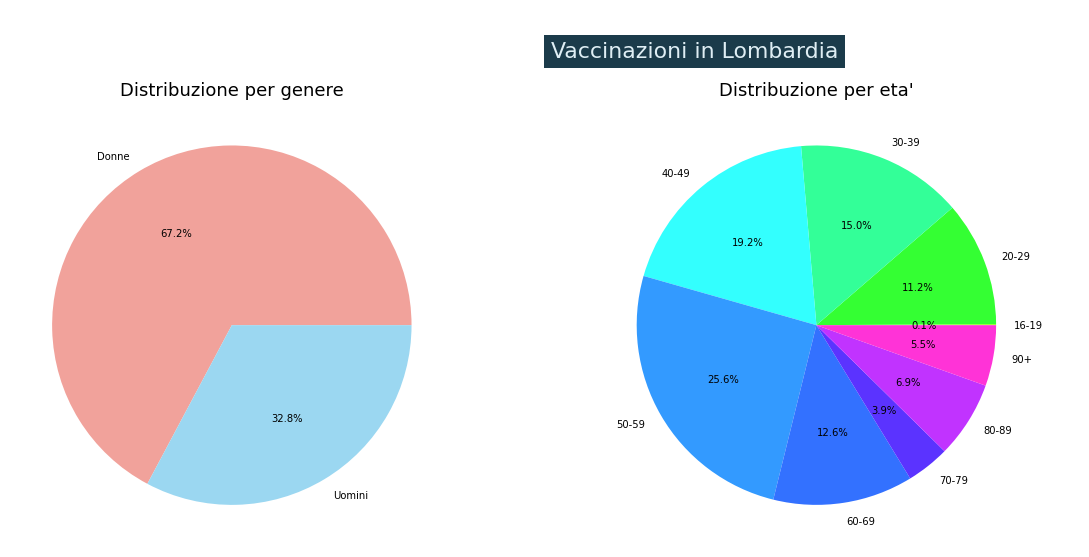

In [15]:
region_name = "Lombardia"
mask_region = (df["nome_area"] == region_name)&&(df["nome_area"] == region_name)
df_region = df.loc[mask_region,["data_somministrazione","nome_area","fornitore","sesso_maschile","sesso_femminile","fascia_anagrafica"]]

fig = plt.figure(figsize=(20, 10))
gs1 = gridspec.GridSpec(2, 2
                       ,figure=fig 
                       ,hspace=0.2
                       ,wspace=0.1
                       ,height_ratios=[1, 10]
                       ,width_ratios=[10, 10])
ax = []

idx = 0
ax.append(fig.add_subplot(gs1[0,1]))
text_box(ax[idx], "Vaccinazioni in {re}".format(re=region_name), fontsize=22, colors=["#1b3b4a", "#dfeef4"])

idx += 1
ax.append(fig.add_subplot(gs1[1,0]))
result = chart_vaccinations_male_female(df_region, ax=ax[idx])

idx += 1
ax.append(fig.add_subplot(gs1[1,1]))
result = age_distribution(df_region, ax=ax[idx], gender="B")


In [18]:
mask_region = df["nome_area"] == "Lombardia"
df_region = df.loc[mask_region,["data_somministrazione","nome_area","fornitore","sesso_maschile","sesso_femminile","fascia_anagrafica"]]
by_age = df_region.groupby(["fascia_anagrafica"]).sum()
by_age.reset_index(level=0, inplace=True)
by_age["totals"] = by_age["sesso_femminile"] + by_age["sesso_maschile"]
by_age

,fascia_anagrafica,sesso_maschile,sesso_femminile,totals
0,16-19,213,359,572
1,20-29,19322,41802,61124
2,30-39,30385,51918,82303
3,40-49,30693,75735,106428
4,50-59,39725,104074,143799
5,60-69,32732,38166,70898
6,70-79,12489,8833,21322
7,80-89,7610,22508,30118
8,90+,3560,24098,27658


In [14]:
mask = df_region["fascia_anagrafica"] == "70-79"
df_region.loc[mask, ["sesso_maschile"]].sum()

sesso_maschile    12489
dtype: int64